# Emulating the LHC Output
TO DO: redo plots in this notebook with updated processed data (fixed ameans)

In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cf_xarray
from scipy import stats
from sklearn.model_selection import train_test_split

## Read inputs (parameter scaling factors)

In [2]:
x = xr.open_dataarray('./processed_data/lhc220926.nc')

In [3]:
x

<xarray.DataArray (param: 32, ens: 500)>
array([[0.778311, 0.319329, 0.876772, ..., 0.185969, 0.26213 , 0.422114],
       [0.358026, 0.548803, 0.210794, ..., 0.996422, 0.91228 , 0.839212],
       [0.255021, 0.630191, 0.662125, ..., 0.422209, 0.533934, 0.144342],
       ...,
       [0.393617, 0.041084, 0.819746, ..., 0.242643, 0.71595 , 0.21237 ],
       [0.078962, 0.275619, 0.840143, ..., 0.842275, 0.353015, 0.36344 ],
       [0.684588, 0.878455, 0.951915, ..., 0.731144, 0.358052, 0.15671 ]])
Coordinates:
  * param    (param) object 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [4]:
x.shape

(32, 500)

In [5]:
xt = x.transpose()
xt.shape

(500, 32)

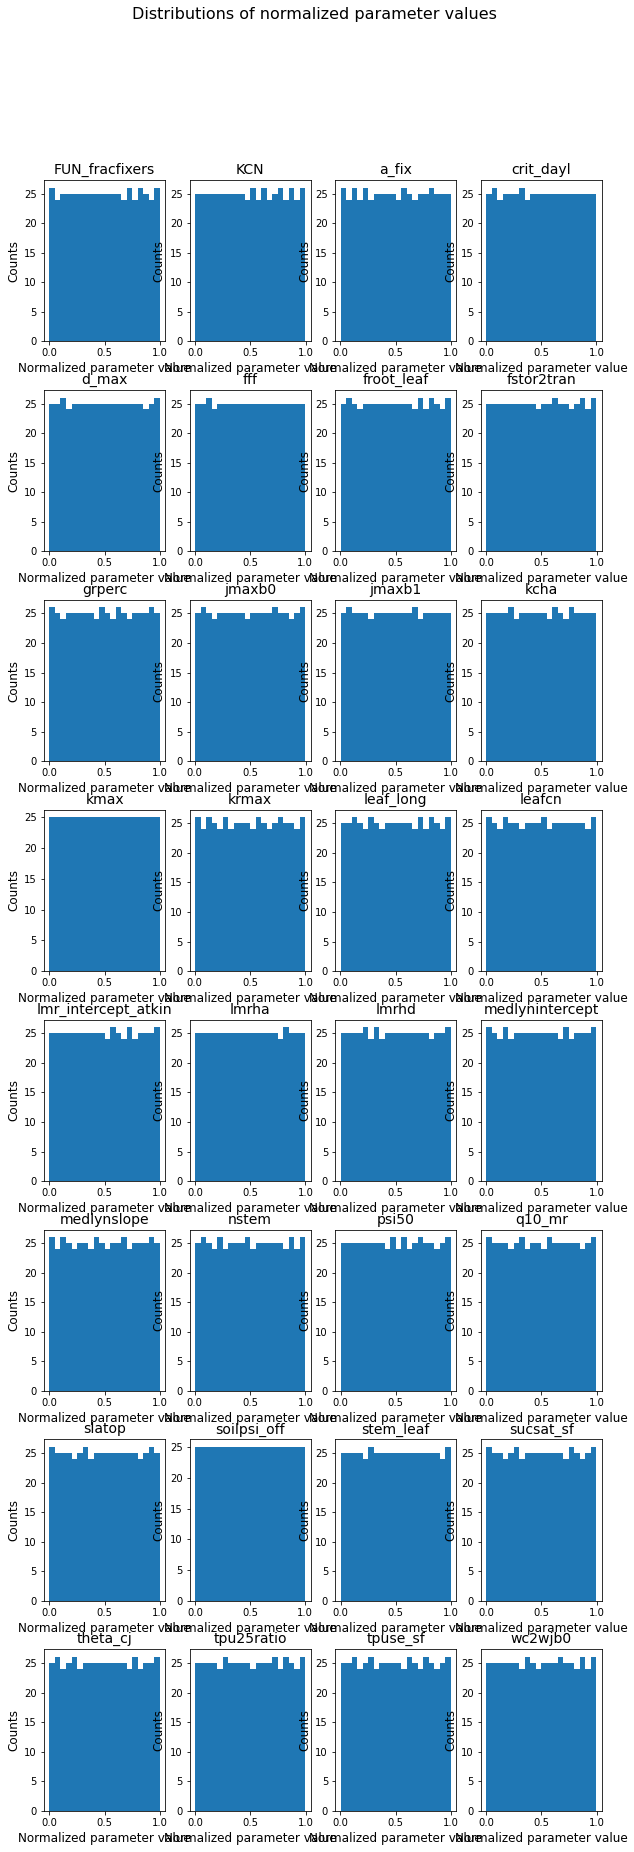

In [6]:
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(10,30))
ax = axs.ravel()

for i,p in enumerate(x.param.values):
    ax[i].hist(x.sel(param=p), bins=20)
    ax[i].set_xlabel('Normalized parameter value', fontsize=12)
    ax[i].set_ylabel('Counts', fontsize=12)
    ax[i].set_title(str(p), fontsize=14)
    
fig.suptitle('Distributions of normalized parameter values', y=0.96, fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3);
#plt.savefig('../figs/lhc/fivevars_GM_AM_scaled-dist_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

## Read outputs

In [7]:
y = xr.open_dataarray('./processed_data/fivevars_gmean_amean_2005-2014.nc')

In [8]:
y

<xarray.DataArray (var: 5, ens: 501)>
array([[ 2.124994e+00,  2.488403e+00,  2.094031e+00, ...,  1.735267e+00,
         1.792857e+00,  1.977623e+00],
       [ 3.239927e-05,  3.832554e-05,  3.836190e-05, ...,  2.776507e-05,
         2.816218e-05,  3.492068e-05],
       [ 2.888949e+01,  3.061194e+01,  3.192346e+01, ...,  2.939185e+01,
         3.349612e+01,  3.071059e+01],
       [ 3.862459e+01,  4.678233e+01,  4.272905e+01, ...,  3.957385e+01,
         3.842887e+01,  3.911139e+01],
       [-3.651462e-06, -3.432839e-05, -1.005382e-05, ..., -9.461017e-07,
        -5.794953e-06, -1.877650e-05]])
Coordinates:
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT' 'QHR'
  * ens      (ens) object 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'

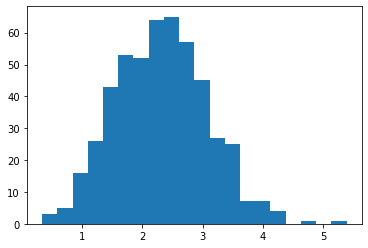

In [9]:
plt.hist(y.sel(var='TLAI'), bins=20);

In [10]:
LAI_metrics = xr.open_dataset('./processed_data/metrics/TLAI.nc')
LAI_metrics

<xarray.Dataset>
Dimensions:                 (ens: 501, biome: 10)
Coordinates:
  * ens                     (ens) int64 0 1 2 3 4 5 ... 495 496 497 498 499 500
  * biome                   (biome) float64 0.0 1.0 2.0 3.0 ... 6.0 7.0 8.0 9.0
    biome_name              (biome) object ...
    degree                  int64 ...
Data variables:
    TLAI_global_avg_2010    (ens) float64 ...
    TLAI_biome_avg_2010     (biome, ens) float64 ...
    TLAI_global_trend_1975  (ens) float64 ...

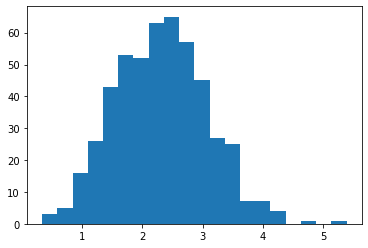

In [11]:
plt.hist(LAI_metrics.TLAI_global_avg_2010[1:], bins=20);

In [14]:
y.shape

(5, 501)

In [16]:
yt_full = y.transpose()
yt_full.shape

(501, 5)

### Remove the default for emulation

In [18]:
yt = yt_full.sel(ens=slice('LHC0001','LHC0500'))
yt

<xarray.DataArray (ens: 500, var: 5)>
array([[ 2.48840346e+00,  3.83255422e-05,  3.06119438e+01,
         4.67823344e+01, -3.43283931e-05],
       [ 2.09403108e+00,  3.83618985e-05,  3.19234644e+01,
         4.27290538e+01, -1.00538247e-05],
       [ 3.76356610e+00,  4.28360268e-05,  2.66754139e+01,
         4.86865687e+01, -1.05297603e-05],
       ...,
       [ 1.73526726e+00,  2.77650705e-05,  2.93918513e+01,
         3.95738546e+01, -9.46101668e-07],
       [ 1.79285669e+00,  2.81621755e-05,  3.34961154e+01,
         3.84288677e+01, -5.79495269e-06],
       [ 1.97762295e+00,  3.49206757e-05,  3.07105945e+01,
         3.91113949e+01, -1.87765041e-05]])
Coordinates:
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT' 'QHR'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

### Rescale the outputs for better emulation performance

In [19]:
y_scale = (yt - yt.mean(dim='ens'))/yt.std(dim='ens')

In [20]:
y_scale.shape

(500, 5)

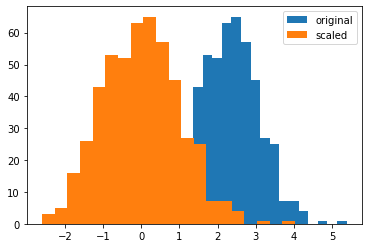

In [21]:
# sanity check rescaling
plt.hist(yt.sel(var='TLAI'), bins=20, label='original')
plt.hist(y_scale.sel(var='TLAI'), bins=20, label='scaled')
plt.legend();

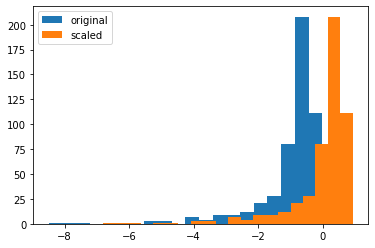

In [24]:
# increase original scale to see it on the same plot
plt.hist(yt.sel(var='QHR')*10**5, bins=20, label='original')
plt.hist(y_scale.sel(var='QHR'), bins=20, label='scaled')
plt.legend();

### Define years

In [22]:
yr0 = 2005
yr1 = 2014

In [111]:
# Random seed for reproducibility
#np.random.seed(9)

## Gaussian Process Regression

### Using scikit learn
See: ``gp_regression.ipynb``

In [24]:
## gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
# key factors include setting up kernel, chosing alpha
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)

In [318]:
# Separate training/testing data: 80/20 split
# Randomly using sklearn
from sklearn.model_selection import train_test_split
x_train_GP,x_test_GP,y_train_GP,y_test_GP = train_test_split(xt,y_scale,test_size=0.2,train_size=0.8)

In [32]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train_GP, y_train_GP);

In [33]:
gp.kernel_

2.46**2 * RBF(length_scale=4.04)

In [34]:
# Testing data for prediction
y_pred, sigma = gp.predict(x_test_GP, return_std=True) # note that y_pred & sigma don't have coordinate labels (numpy array)

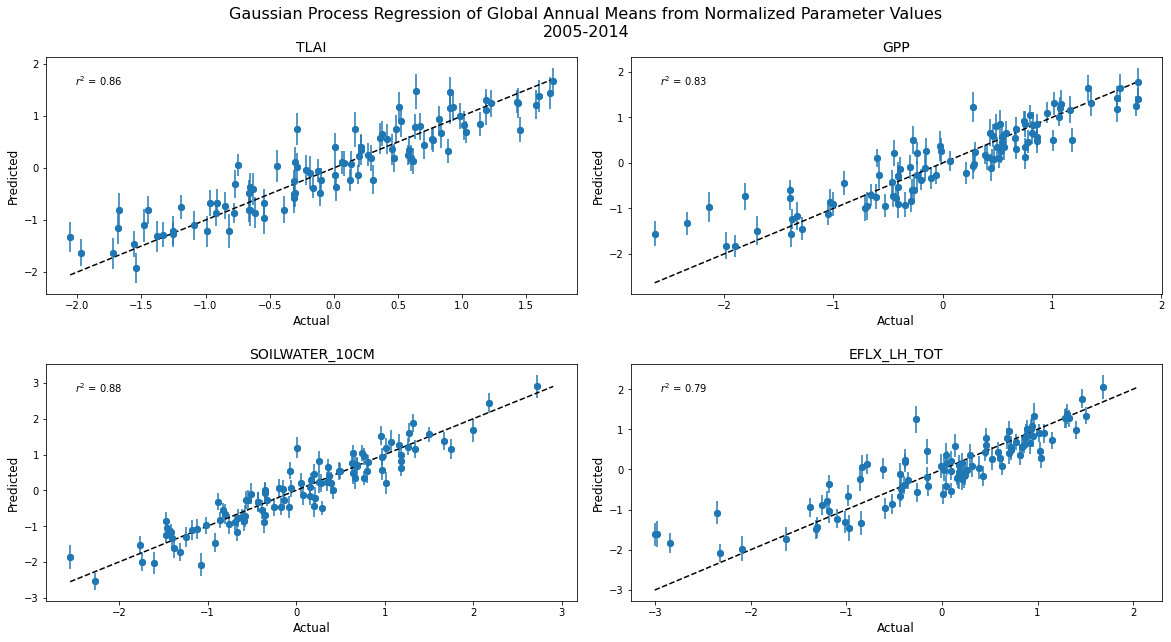

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_GP.sel(var=v),y_pred[:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)
    # standard deviation as error bars
    ax[i].errorbar(y_test_GP.sel(var=v),y_pred[:,i], yerr=sigma[:,i], fmt="o")

    # bounds for one-to-one line
    bounds = (np.amin([y_test_GP.sel(var=v),y_pred[:,i]]),np.amax([y_test_GP.sel(var=v),y_pred[:,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_GP.sel(var=v),y_pred[:,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means from Normalized Parameter Values\n2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate variables vs. kmax with all other params set at 0.5
First using test data

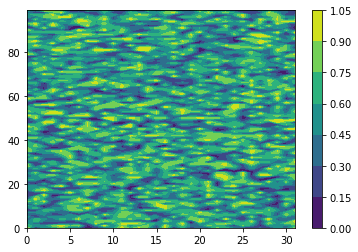

In [64]:
plt.contourf(x_test_GP)
plt.colorbar();

In [65]:
x_test_GP_kmax = x_test_GP.where(x_test_GP.param=='kmax', other=0.5)

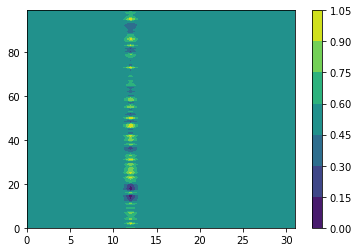

In [66]:
plt.contourf(x_test_GP_kmax)
plt.colorbar();

In [67]:
# Testing data for prediction
y_pred_kmax, sigma = gp.predict(x_test_GP_kmax, return_std=True)

In [70]:
sigma.shape

(100, 4)

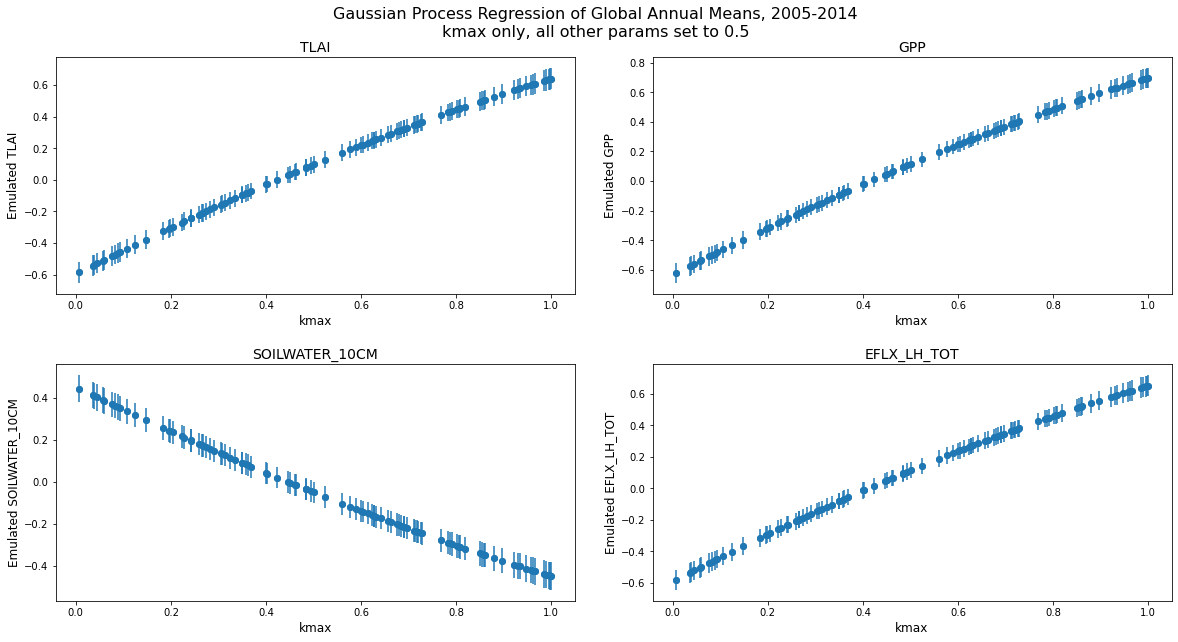

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_test_GP.sel(param='kmax'),y_pred_kmax[:,i])
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    # standard deviation as error bars
    ax[i].errorbar(x_test_GP.sel(param='kmax'),y_pred_kmax[:,i], yerr=sigma[:,i], fmt="o")
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_kmax_testdata_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [75]:
nsamp = 1000
x_oos = np.random.rand(nsamp,xt.shape[1])

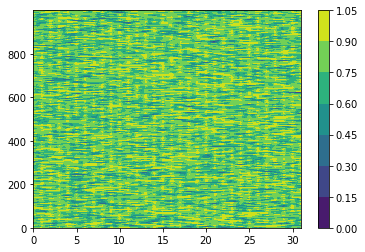

In [76]:
plt.contourf(x_oos)
plt.colorbar();

In [80]:
# label dimensions to enable parameter indexing
x_oos_da = xr.DataArray(x_oos,dims=('ens','param'),coords=dict(param=x.param))

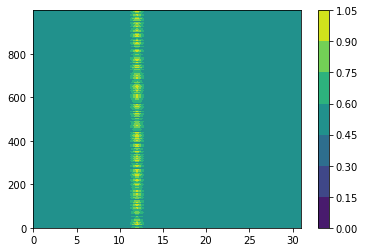

In [81]:
x_oos_kmax = x_oos_da.where(x_oos_da.param=='kmax', other=0.5)
plt.contourf(x_oos_kmax)
plt.colorbar();

In [82]:
y_pred_kmax_oos, sigma_oos = gp.predict(x_oos_kmax, return_std=True)

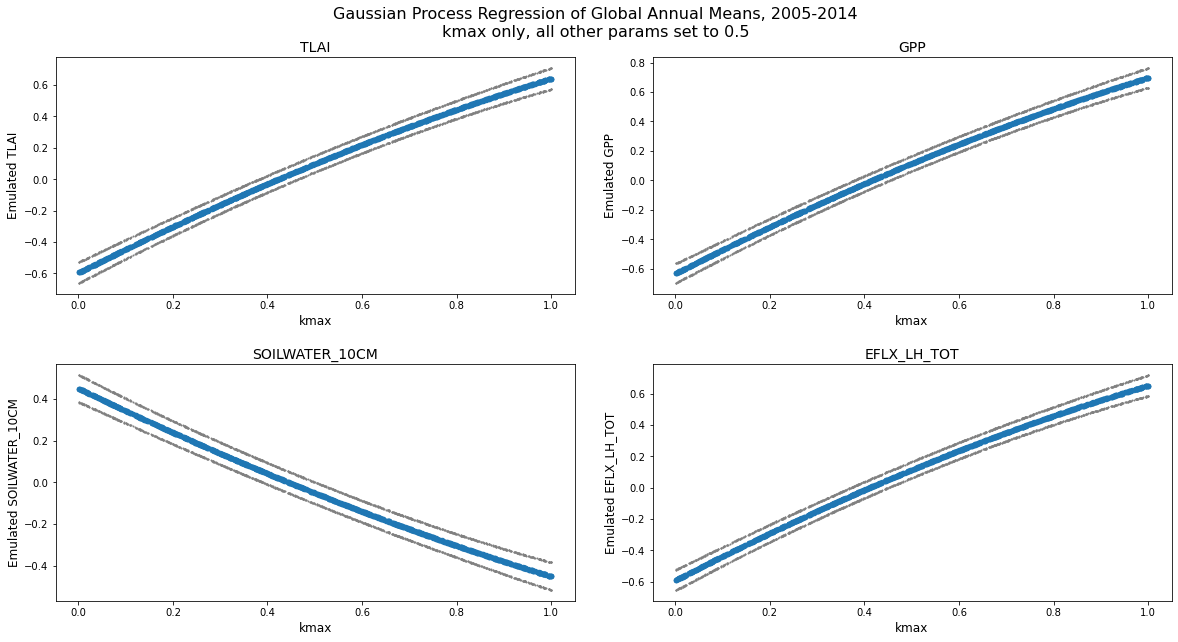

In [87]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'),y_pred_kmax_oos[:,i], s=20)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    # standard deviation as error bars
    #ax[i].errorbar(x_oos_da.sel(param='kmax'),y_pred_kmax_oos[:,i], yerr=sigma_oos[:,i], fmt="o")
    # standard deviation as points
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]-sigma_oos[:,i], s=1, c='grey')
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]+sigma_oos[:,i], s=1, c='grey')
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Using ESEm
See: https://esem.readthedocs.io/en/latest/emulation.html#gaussian-processes-emulation \
https://esem.readthedocs.io/en/latest/examples/Emulating_using_GPs.html

In [23]:
from esem import gp_model
from esem.utils import get_random_params

2023-01-06 17:33:00.957395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 17:33:02.432511: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-06 17:33:03.634304: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-06 17:33:19.187064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [27]:
x2_train_GP,x2_test_GP,y2_train_GP,y2_test_GP = train_test_split(xt,y_scale,test_size=0.2,train_size=0.8)

In [28]:
y2_train_GP

<xarray.DataArray (ens: 400, var: 5)>
array([[ 1.45874003e+00,  1.82154439e+00, -8.86678992e-01,
         1.19126895e+00,  1.75662355e-01],
       [-6.30070369e-01, -1.92661832e-01, -1.80894655e-01,
         8.23552158e-01,  5.26907123e-01],
       [-6.16268085e-01, -4.62290128e-01, -1.57817048e-03,
        -6.62580437e-01,  3.15814114e-01],
       ...,
       [ 3.09727308e-01,  4.55480551e-01,  4.39220763e-02,
        -5.53479601e-01,  2.85327575e-01],
       [-2.42029649e+00, -3.23264361e+00,  1.88098002e+00,
        -3.11146629e+00,  6.13211972e-01],
       [ 6.68685304e-01,  6.72583848e-01, -1.76472085e+00,
         9.34085513e-01,  4.95005295e-01]])
Coordinates:
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT' 'QHR'
  * ens      (ens) object 'LHC0197' 'LHC0255' 'LHC0056' ... 'LHC0067' 'LHC0474'

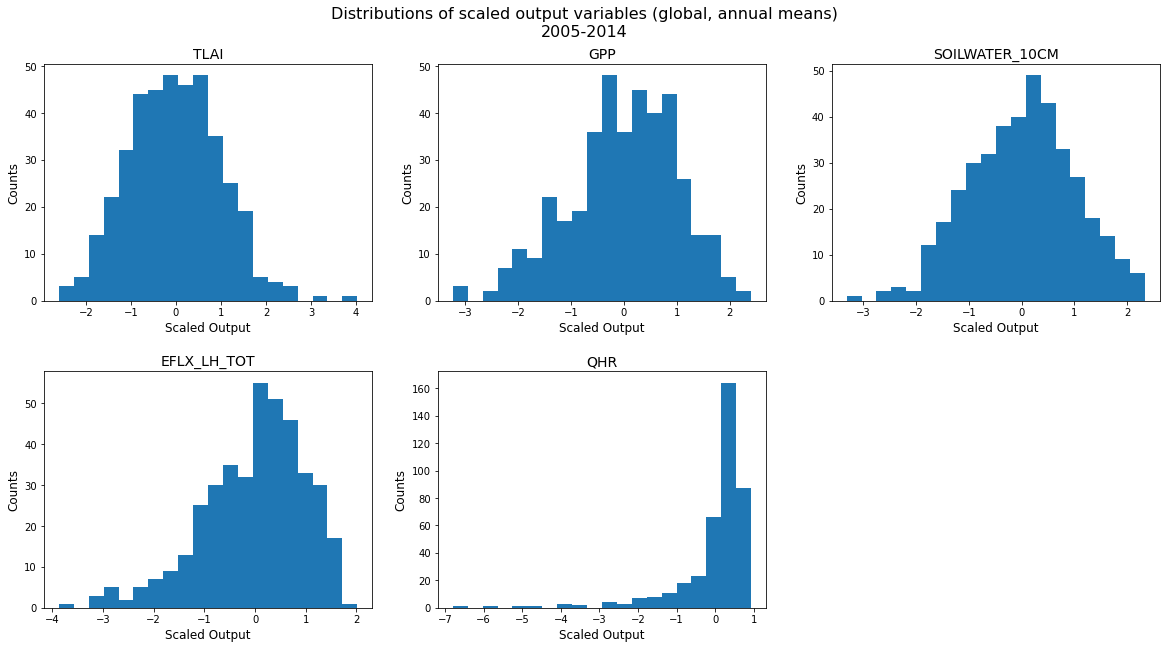

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].hist(y2_train_GP.sel(var=v), bins=20)
    ax[i].set_xlabel('Scaled Output', fontsize=12)
    ax[i].set_ylabel('Counts', fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
fig.delaxes(ax[5]) # remove extra axes
fig.suptitle('Distributions of scaled output variables (global, annual means)\n'+str(yr0)+'-'+str(yr1), y=0.96, fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3);
#plt.savefig('../figs/lhc/fivevars_GM_AM_scaled-dist_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [32]:
# use the previously defined training sets
# x needs a .values because it won't take xarray data arrays (but y will)
# adding a .values for y as well because there are errors in .predict later on (something about coordinates, doesn't like string coordinate values?)

#model_gp = gp_model(x_train_GP.values, y_train_GP.values) # default kernel is 'a combination of linear, RBF and polynomial kernels'
#model_gp = gp_model(x_train_GP.values, y_train_GP.values, kernel=['Linear', 'Cosine'], kernel_op='add') # degrades performance
model_gp = gp_model(x2_train_GP.values, y2_train_GP.values)

/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."


/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
2023-01-06 17:37:51.184911: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-06 17:37:51.184962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc47): /proc/driver/nvidia/version does not exist
2023-01-06 17:37:51.189069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in o

In [33]:
model_gp.train()

In [35]:
x2_test_GP.values.shape

(100, 32)

In [36]:
#mean, variance = model_gp.predict(x_test_GP.values)
mean, variance = model_gp.predict(x2_test_GP.values)

In [37]:
mean.shape

(100, 5)

In [38]:
variance.shape

(100, 5)

In [39]:
## Note the model variance is constant across the outputs
variance.max(axis=0)

array([0.22172846, 0.22172846, 0.22172846, 0.22172846, 0.22172846])

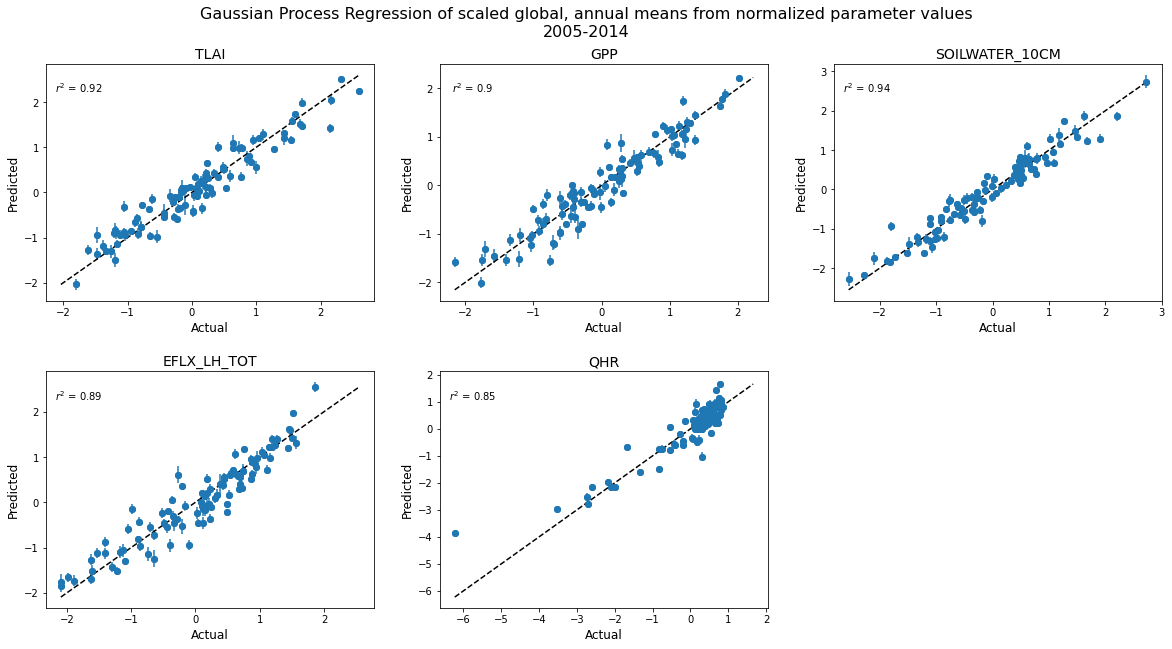

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y2_test_GP.sel(var=v),mean[:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)
    # standard deviation as error bars
    ax[i].errorbar(y2_test_GP.sel(var=v),mean[:,i], yerr=variance[:,i], fmt="o")

    # bounds for one-to-one line
    bounds = (np.amin([y2_test_GP.sel(var=v),mean[:,i]]),np.amax([y2_test_GP.sel(var=v),mean[:,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y2_test_GP.sel(var=v),mean[:,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.delaxes(ax[5]) # remove extra axes
fig.suptitle('Gaussian Process Regression of scaled global, annual means from normalized parameter values\n'+str(yr0)+'-'+str(yr1), y=0.96, fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.3);
#plt.savefig('../figs/lhc/fivevars_GM_AM_GPR-ESEm_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [73]:
get_random_params(xt.shape[1], int(1e3)).shape

(1000, 32)

In [66]:
m, sd = model_gp.batch_stats(get_random_params(xt.shape[1], int(1e3)))

  0%|          | 0/1000 [00:00<?, ?sample/s]

In [68]:
# not exactly sure what these values represent - how are the multiple output variables combined?
print(m, sd)

0.032938571354283186 0.968606789790772


In [74]:
mean_oos, variance_oos = model_gp.predict(get_random_params(xt.shape[1], int(1e2)))

### TLAI only

In [46]:
x2_train_GP_TLAI,x2_test_GP_TLAI,y2_train_GP_TLAI,y2_test_GP_TLAI = train_test_split(xt,y_scale.sel(var='TLAI'),test_size=0.2,train_size=0.8)

In [47]:
model_gp_TLAI = gp_model(x2_train_GP_TLAI.values, y2_train_GP_TLAI.values)

In [49]:
model_gp_TLAI.train()

In [50]:
mean_TLAI, variance_TLAI = model_gp_TLAI.predict(x2_test_GP_TLAI.values)

In [53]:
variance_TLAI

array([0.04255954, 0.02878637, 0.05377512, 0.04138001, 0.04635213,
       0.07218128, 0.02422337, 0.01966594, 0.03914247, 0.02785116,
       0.07415535, 0.05049101, 0.0327534 , 0.05816235, 0.02169162,
       0.03323244, 0.01854397, 0.03965205, 0.02485137, 0.02038728,
       0.04130062, 0.0343625 , 0.05587578, 0.03864369, 0.03495723,
       0.04163015, 0.03460375, 0.01878104, 0.0348984 , 0.05670346,
       0.05046441, 0.05619324, 0.05880553, 0.03138152, 0.03196487,
       0.0596898 , 0.04060653, 0.02442433, 0.02026626, 0.02895771,
       0.09455846, 0.03658212, 0.02878974, 0.03396187, 0.02387419,
       0.05186029, 0.03554035, 0.02999972, 0.03413216, 0.02997421,
       0.04818614, 0.0567835 , 0.03535211, 0.0388819 , 0.0188787 ,
       0.06908652, 0.02904819, 0.03428123, 0.03872389, 0.05483107,
       0.0419732 , 0.04468049, 0.03428769, 0.03867471, 0.04673006,
       0.02341475, 0.08036921, 0.04292326, 0.02623406, 0.02222922,
       0.0364959 , 0.03544577, 0.03379347, 0.08327472, 0.02212

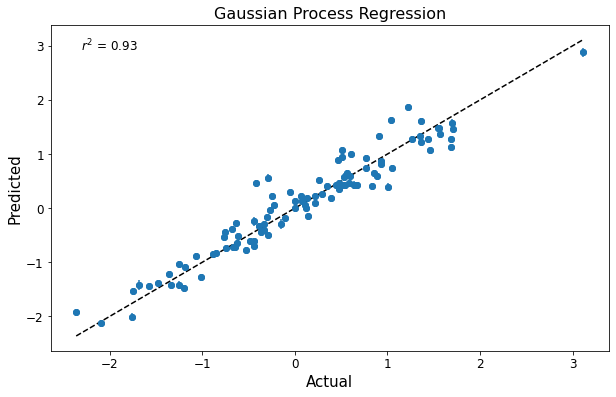

In [88]:
fig = plt.figure(figsize=(10,6))

plt.scatter(y2_test_GP_TLAI,mean_TLAI)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# standard deviation as error bars
plt.errorbar(y2_test_GP_TLAI, mean_TLAI, yerr=variance_TLAI, fmt="o")

# bounds for one-to-one line
bounds = (np.amin([y2_test_GP_TLAI,mean_TLAI]),np.amax([y2_test_GP_TLAI,mean_TLAI]))

# one-to-one line
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

# r^2 calculation and display
slope, intercept, r_value, p_value, std_err = stats.linregress(y2_test_GP_TLAI,mean_TLAI)
pltstr = "$r^2$ = %.2g" % r_value**2
plt.text(-2, 3, pltstr, horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.title('Gaussian Process Regression', fontsize=16)
    
#plt.savefig('../figs/lhc/TLAI_GM_AM_GPR-ESEm_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

## Neural Networks

### Using keras - ANNs

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.backend as K

In [69]:
inputdata=xt
#outputdata=y_scale
outputdata = y_scale.sel(var='TLAI')

In [70]:
outputdata.shape

(500,)

In [71]:
# Separate training/testing/validation data: 60/20/20 split
xi,x_test,yi,y_test = train_test_split(inputdata,outputdata,test_size=0.2,train_size=0.8)
x_train,x_val,y_train,y_val = train_test_split(xi,yi,test_size=0.25,train_size=0.75)

In [74]:
# Create 2-layer simple model
model = Sequential()

# specify input_dim as number of parameters, not number of simulations
# test 10 nodes in first hidden layer
# l2 norm regularizer
model.add(Dense(10, input_dim=inputdata.shape[1], activation='relu', kernel_regularizer=l2(.001)))

# second layer with hyperbolic tangent activation
# test 5 nodes in second hidden layer
model.add(Dense(5, activation='tanh', kernel_regularizer=l2(.001)))

# output layer with linear activation
#model.add(Dense(outputdata.shape[1]))
model.add(Dense(1)) # single output

In [75]:
# Define model metrics
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [76]:
# Compile model with RMSprop optimization

# define learning rate
lr = 0.005
#lr = 0.01

#opt_dense = RMSprop(lr=0.005, rho=0.9, epsilon=1e-07, decay=0.0)
opt_dense = RMSprop(lr=lr)
model.compile(opt_dense, "mse", metrics=[mean_sq_err])

/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [77]:
# Fit the model w/ EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=1, patience=50, verbose=1, mode='min')
results = model.fit(x_train, y_train, epochs=500, batch_size=30, callbacks=[es], verbose=0, validation_data=(x_test,y_test))

# Fit the model w/o EarlyStopping
#results = model.fit(x_train, y_train, epochs=500, batch_size=30, verbose=0, validation_data=(x_test,y_test))

Epoch 51: early stopping


In [78]:
print("Training Mean Error:", results.history['mean_sq_err'][-1])
print("Validation Mean Error:", results.history['val_mean_sq_err'][-1])

Training Mean Error: 0.17108871042728424
Validation Mean Error: 0.1521533578634262


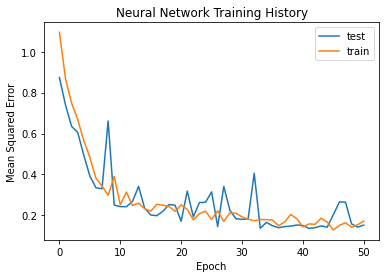

In [79]:
# Plot training history by epoch
plt.plot(results.epoch, results.history['val_mean_sq_err'], label='test')
plt.plot(results.epoch, results.history['mean_sq_err'], label='train')
#plt.xticks(results.epoch)
plt.legend()
#plt.hlines(y=0,xmin=0,xmax=15)
#plt.hlines(y=0,xmin=0,xmax=40)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.title('Neural Network Training History');

In [80]:
# Make predictions - using validation set
model_preds = model.predict(x_val)

4/4 [==============================] - 0s 2ms/step


In [82]:
# model metric for predictions
def mse_preds(y_true,y_pred):
    return np.mean((y_true-y_pred)**2)

In [85]:
# calculate model mean error with predictions
#model_me = mse_preds(y_val, model_preds)
model_me = mse_preds(y_val, model_preds[:,0]) # single output
print("Prediction Mean Error: ", model_me.values)

Prediction Mean Error:  0.20928113247270397


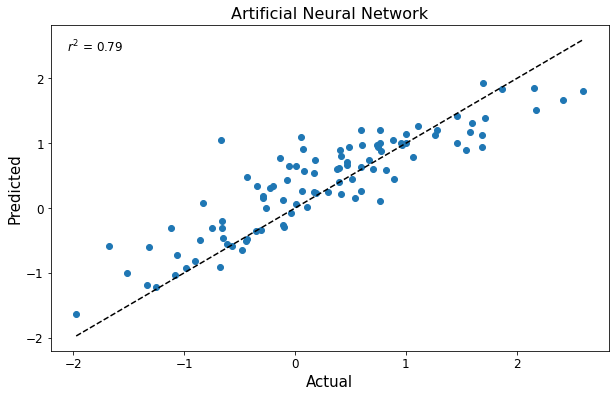

In [92]:
# plot actual vs. predicted - single output
fig = plt.figure(figsize=(10,6))

plt.scatter(y_val,model_preds[:,0])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# bounds for one-to-one line
bounds = (np.amin([y_val,model_preds[:,0]]),np.amax([y_val,model_preds[:,0]]))

# one-to-one line
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

# r^2 calculation and display
slope, intercept, r_value, p_value, std_err = stats.linregress(y_val,model_preds[:,0])
pltstr = "$r^2$ = %.2g" % r_value**2
plt.text(-1.8, 2.5, pltstr, horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.title('Artificial Neural Network', fontsize=16)
    
#plt.savefig('../figs/lhc/TLAI_GM_AM_NN_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

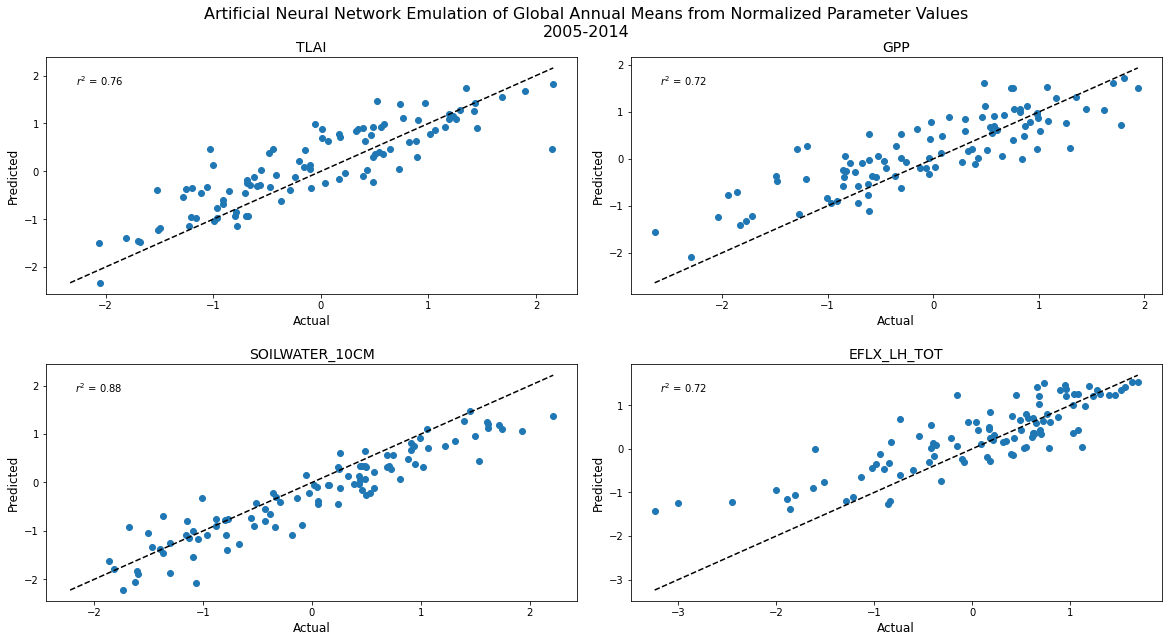

In [111]:
# plot actual vs. predicted - multiple outputs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_val.sel(var=v), model_preds[:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
    # bounds for one-to-one line
    bounds = (np.amin([y_val.sel(var=v),model_preds[:,i]]),np.amax([y_val.sel(var=v),model_preds[:,i]]))
    
    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--')
    
    # linear regression of actual vs predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_val[:,i], model_preds[:,i])
    
    # r^2 value
    pltstr = "$r^2$ = %.2g" % r_value**2
    plt.text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
    
fig.suptitle('Artificial Neural Network Emulation of Global Annual Means from Normalized Parameter Values\n2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate GPP vs. kmax with all other params set at 0.5
First using validation data

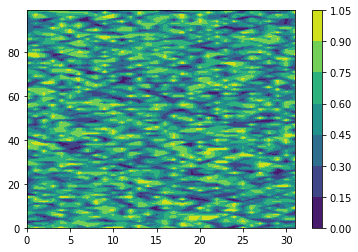

In [158]:
plt.contourf(x_val)
plt.colorbar();

In [159]:
x_val_kmax = x_val.where(x_val.param=='kmax', other=0.5)

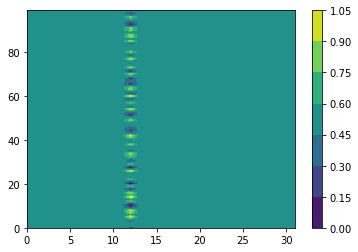

In [160]:
plt.contourf(x_val_kmax)
plt.colorbar();

In [161]:
# Validation data for prediction
model_preds_kmax = model.predict(x_val_kmax)

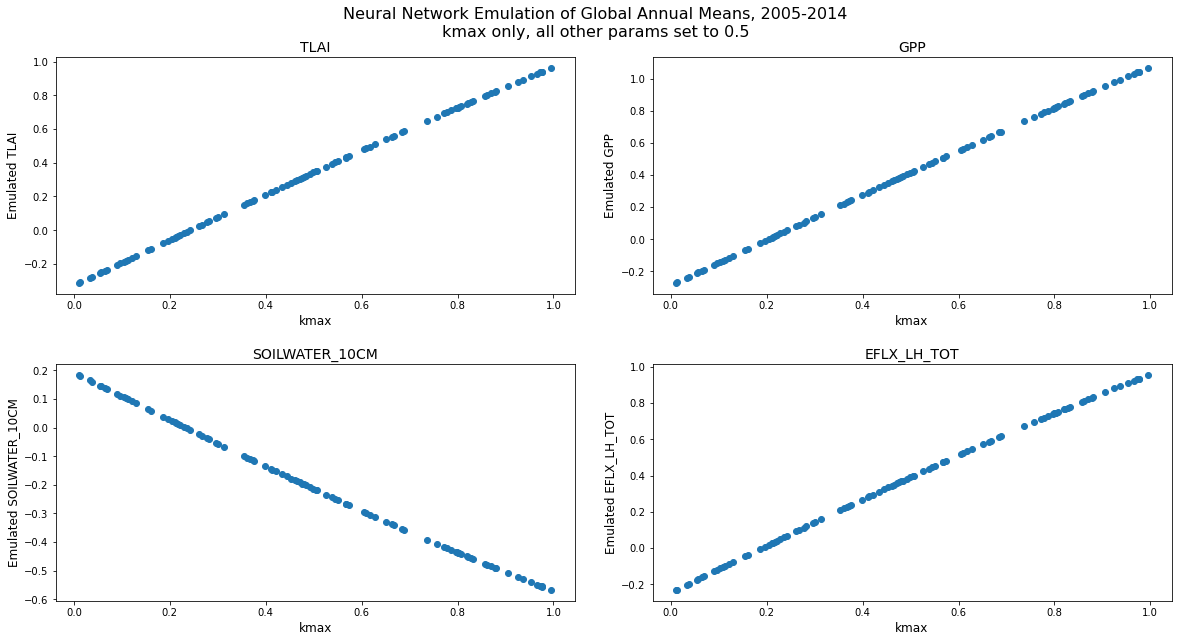

In [163]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_val.sel(param='kmax'),model_preds_kmax[:,i])
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Neural Network Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_kmax_testdata_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [164]:
model_preds_kmax_oos = model.predict(x_oos_kmax)

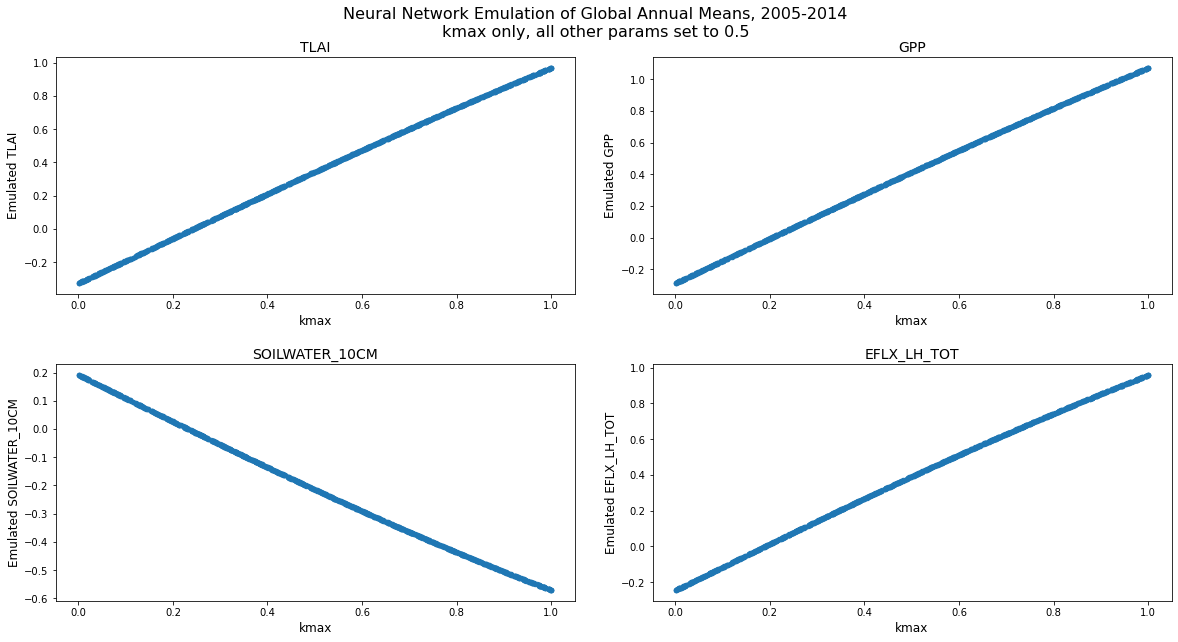

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'),model_preds_kmax_oos[:,i], s=20)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Neural Network Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compare response curves

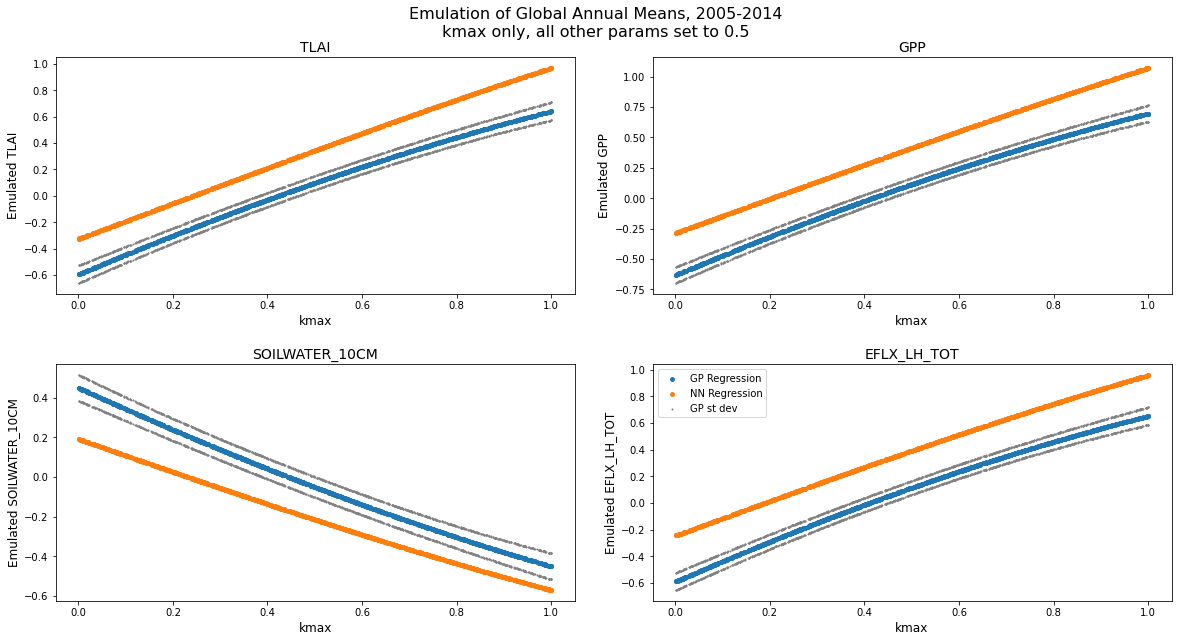

In [169]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i], label='GP Regression', s=15)
    ax[i].scatter(x_oos_da.sel(param='kmax'), model_preds_kmax_oos[:,i], label='NN Regression', s=15)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]-sigma_oos[:,i], s=1, c='grey', label='GP st dev')
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]+sigma_oos[:,i], s=1, c='grey')
    ax[i].set_title(str(v), fontsize=14)

plt.legend()

fig.suptitle('Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_NN_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Using ESEm - CNNs
See: https://esem.readthedocs.io/en/latest/emulation.html#neural-network-emulation \
https://esem.readthedocs.io/en/latest/examples/Emulating_using_ConvNets.html

In [112]:
from esem import cnn_model

In [119]:
# need 3D data for CNNs - import global mean, monthly climatologies to include a time dimension
y_climo = xr.open_dataarray('./processed_data/fourvars_gmean_mclimo_2005-2014.nc')
y_climo

<xarray.DataArray (var: 4, ens: 500, month: 12)>
array([[[2.328943e+00, 2.251743e+00, ..., 2.463620e+00, 2.441013e+00],
        [1.907430e+00, 1.854050e+00, ..., 2.047201e+00, 1.999152e+00],
        ...,
        [1.637278e+00, 1.581882e+00, ..., 1.789621e+00, 1.743971e+00],
        [1.833542e+00, 1.775463e+00, ..., 1.931492e+00, 1.920382e+00]],

       [[2.915380e-05, 2.942261e-05, ..., 2.990950e-05, 2.934111e-05],
        [2.911165e-05, 2.965912e-05, ..., 2.985165e-05, 2.916091e-05],
        ...,
        [2.123405e-05, 2.161983e-05, ..., 2.195818e-05, 2.149967e-05],
        [2.678273e-05, 2.724689e-05, ..., 2.660233e-05, 2.650120e-05]],

       [[3.308837e+01, 3.335172e+01, ..., 3.091942e+01, 3.245255e+01],
        [3.446497e+01, 3.470672e+01, ..., 3.230726e+01, 3.387454e+01],
        ...,
        [3.612997e+01, 3.628945e+01, ..., 3.402658e+01, 3.559276e+01],
        [3.319233e+01, 3.342057e+01, ..., 3.116482e+01, 3.262966e+01]],

       [[3.638907e+01, 3.706767e+01, ..., 3.723816e+01, 3.612266e+01],
        [3.326599e+01, 3.456015e+01, ..., 3.395316e+01, 3.271479e+01],
        ...,
        [3.003784e+01, 3.125036e+01, ..., 3.050913e+01, 2.959025e+01],
        [3.036943e+01, 3.138829e+01, ..., 3.079923e+01, 2.979704e+01]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [125]:
yt_climo = y_climo.transpose('ens','month','var')
yt_climo.shape

(500, 12, 4)

In [127]:
y_climo_scale = (yt_climo - yt_climo.mean(dim='ens'))/yt_climo.std(dim='ens')

In [128]:
y_climo_scale.shape

(500, 12, 4)

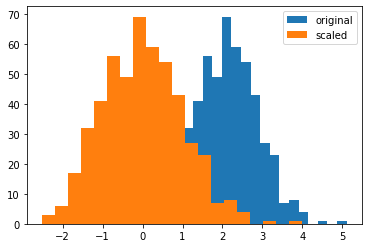

In [130]:
# sanity check rescaling
plt.hist(yt_climo.sel(month=1, var='TLAI'), bins=20, label='original')
plt.hist(y_climo_scale.sel(month=1, var='TLAI'), bins=20, label='scaled')
plt.legend();

In [224]:
x_train_CNN,x_test_CNN,y_train_CNN,y_test_CNN = train_test_split(xt,y_climo_scale,test_size=0.2,train_size=0.8)
#x_train_CNN,x_test_CNN,y_train_CNN,y_test_CNN = train_test_split(xt,yt_climo,test_size=0.2,train_size=0.8) # try without rescaled values (rescaling does appear to help skill)

In [225]:
# use the same train/test split as for GPs
# need 3D y values
model_cnn = cnn_model(x_train_CNN.values, y_train_CNN.values, activation='linear') # default final activation is tanh, which reduces outputs to [0,1] - use linear instead (same as ANN)

In [226]:
model_cnn.train()

Epoch 1/100
40/40 [==============================] - 1s 5ms/step - loss: 1.0084 - val_loss: 0.9073
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.9673 - val_loss: 0.8668
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9085 - val_loss: 0.7979
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.8320 - val_loss: 0.7406
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.7470 - val_loss: 0.6594
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.6730 - val_loss: 0.6100
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.6119 - val_loss: 0.5723
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.5577 - val_loss: 0.5107
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5150 - val_loss: 0.4801
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4758 - val_loss: 0.4631
Epoch 11/

In [227]:
mean_cnn, variance_cnn = model_cnn.predict(x_test_CNN.values)

In [228]:
mean_cnn.shape

(100, 12, 4)

In [229]:
variance_cnn.shape

(100, 12, 4)

In [230]:
y_test_CNN.shape

(100, 12, 4)

In [231]:
# variance is nans! doesn't work for CNNs?
variance_cnn[:,10,2]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [ ]:
# Question: how to visualize the monthly skill?
# Can start with scatterplot for individual months

In [232]:
y_test_CNN.sel(var='TLAI', month=1)

<xarray.DataArray (ens: 100)>
array([ 1.56595928, -0.73761681, -1.83095465, -0.18271983,  0.04253625,
       -0.77213868, -0.7733433 , -0.12749088,  0.06622888, -1.78142195,
       -0.98043035, -1.58125645,  0.37681743, -1.52511347,  0.23636414,
        1.21123128, -0.26875168,  0.57269119,  0.61102366, -1.66077225,
       -0.14455686,  2.60897847, -0.71985626,  0.22569168,  0.12917805,
        0.90916749, -0.28789242, -1.28125355,  1.3300048 ,  0.86464067,
       -0.3827996 , -1.17166044, -0.31098204,  0.75510561,  0.20547826,
       -0.29152512,  0.57042846, -0.10502144, -1.61439253,  1.74603673,
       -0.41019774, -1.13184036, -1.61399809, -0.03393136, -1.28818618,
       -0.58158827, -0.59497399,  1.3513807 , -0.8605519 , -0.6259231 ,
        0.44322057,  0.10867359, -1.71586536,  0.39142898, -1.01662143,
        0.60382455,  1.68909554,  0.65414441, -0.88080102,  0.94747464,
        2.28442463,  0.74297329, -1.10712083, -1.43882974,  0.66965715,
       -1.17925366,  0.27914454,  1.64454419, -0.35588778, -0.30445393,
        1.19372948,  1.27792943, -0.57053309,  0.72347155, -0.7247235 ,
        0.8303807 , -0.6428634 ,  0.64758366,  1.30713751,  1.17322869,
       -0.05332471, -0.22679987,  0.8776557 ,  1.53111987, -0.20942913,
       -0.33085745,  0.18283918,  0.12647145, -0.26777483,  0.7524364 ,
        0.32946725,  0.42622774, -1.82313901,  0.32715793, -0.94526648,
       -0.72417091,  0.54634049,  0.52745798,  1.71693922, -0.84402375])
Coordinates:
    month    int64 1
    var      <U4 'TLAI'
  * ens      (ens) object 'LHC0152' 'LHC0223' 'LHC0219' ... 'LHC0142' 'LHC0424'

In [233]:
mean_cnn[:,0,0].shape

(100,)

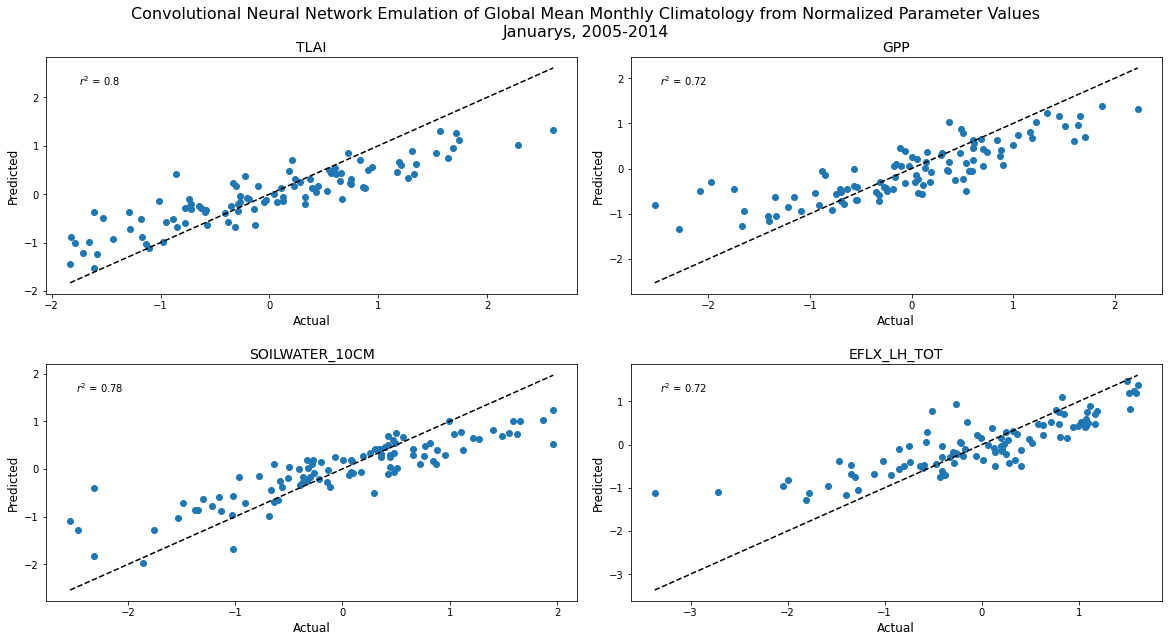

In [290]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

mon=1 # January

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]) # watch the indexing for cnn output
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]),np.amax([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Convolutional Neural Network Emulation of Global Mean Monthly Climatology from Normalized Parameter Values\nJanuarys, 2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_MC_CNN_JAN_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

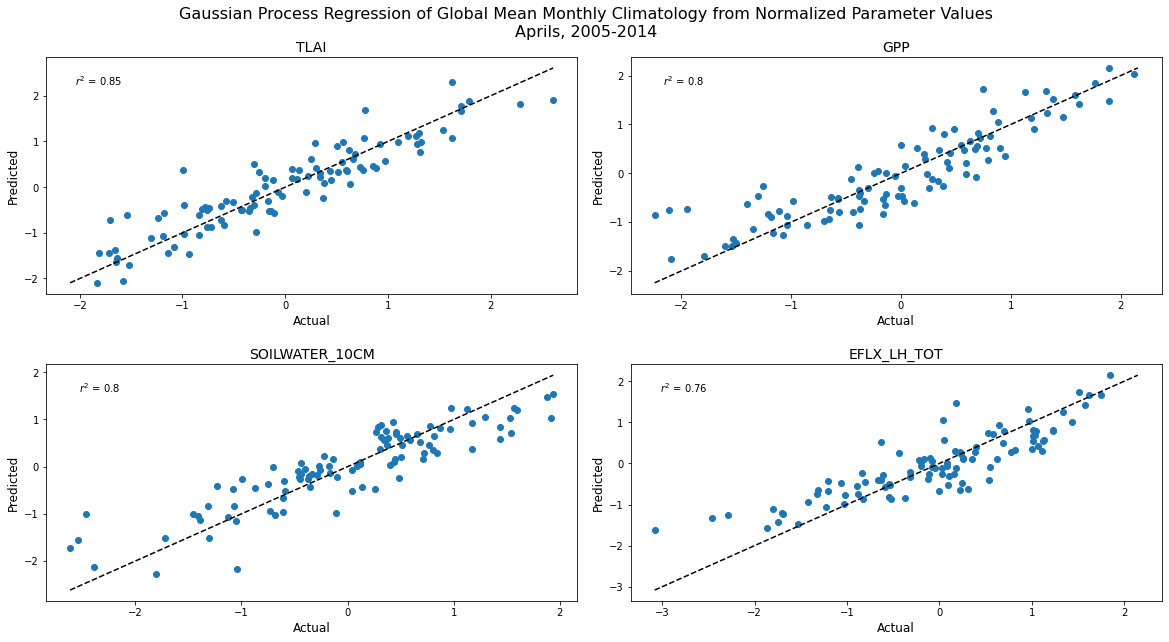

In [235]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

mon=4 # April

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]) # watch the indexing for cnn output
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]),np.amax([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Convolutional Neural Network Emulation of Global Mean Monthly Climatology from Normalized Parameter Values\nAprils, 2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);

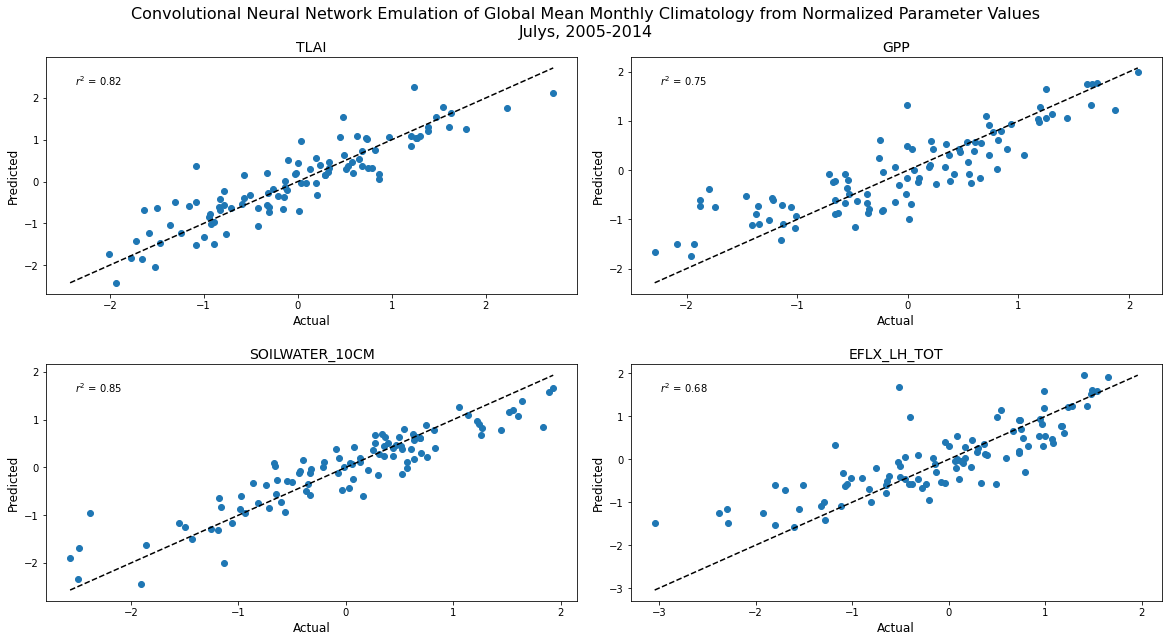

In [291]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

mon=7 # July

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]) # watch the indexing for cnn output
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]),np.amax([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Convolutional Neural Network Emulation of Global Mean Monthly Climatology from Normalized Parameter Values\nJulys, 2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_MC_CNN_JUL_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

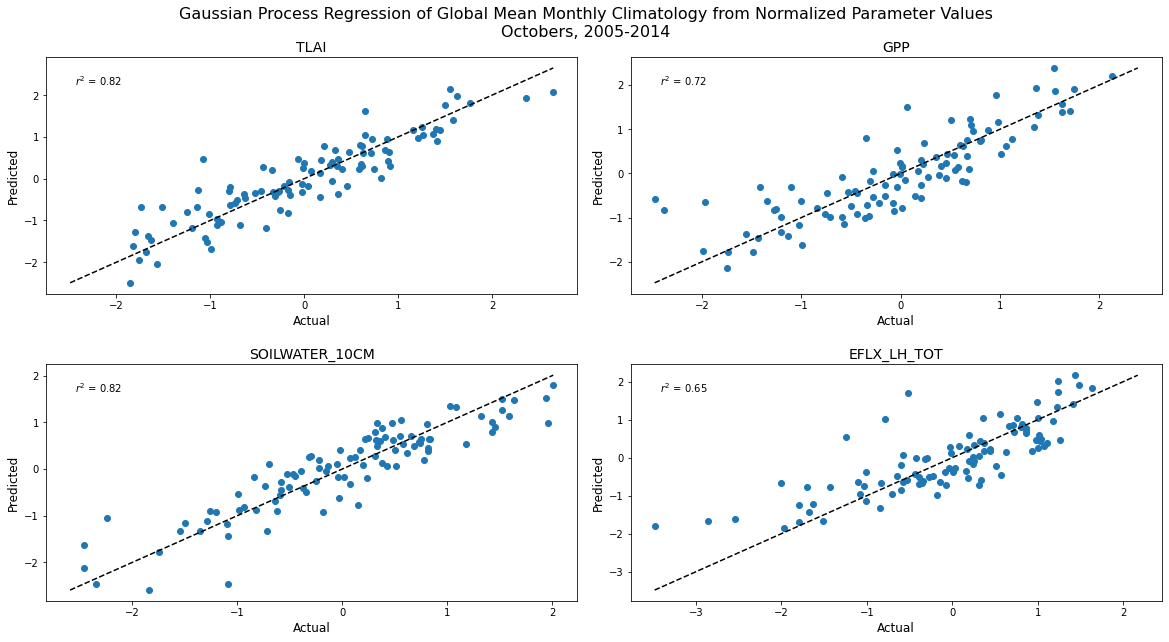

In [237]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

mon=10 # October

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]) # watch the indexing for cnn output
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]),np.amax([y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_CNN.sel(var=v, month=mon),mean_cnn[:,mon-1,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Convolutional Neural Network Emulation of Global Mean Monthly Climatology from Normalized Parameter Values\nOctobers, 2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);

In [239]:
# try quantifying skill by the std spread across months? interannual variability?
y_test_CNN.sel(var='TLAI').std(dim='month')

<xarray.DataArray (ens: 100)>
array([0.13885081, 0.03505616, 0.04737129, 0.01966657, 0.05208681,
       0.01775787, 0.07152625, 0.06459574, 0.0589896 , 0.0308837 ,
       0.0410496 , 0.07626626, 0.0496448 , 0.03020544, 0.06189311,
       0.04112751, 0.05955288, 0.04445783, 0.02283006, 0.13435272,
       0.06392345, 0.05828617, 0.0313433 , 0.0574957 , 0.08950811,
       0.05204579, 0.02491293, 0.0386767 , 0.04299289, 0.03606093,
       0.04936248, 0.03880477, 0.06012059, 0.03684976, 0.08311183,
       0.06152587, 0.05141907, 0.0411054 , 0.0475453 , 0.04363048,
       0.10145103, 0.02525266, 0.03228977, 0.04514479, 0.07515315,
       0.02412479, 0.05261411, 0.03048035, 0.07810598, 0.01720226,
       0.04889454, 0.09412712, 0.05005782, 0.05980768, 0.11306996,
       0.0571532 , 0.1060497 , 0.07201489, 0.03503742, 0.0588851 ,
       0.03589667, 0.06282984, 0.05316835, 0.05468799, 0.09919303,
       0.03157007, 0.03767214, 0.06535855, 0.05596585, 0.02758863,
       0.06256011, 0.05479417, 0.0748571 , 0.10357909, 0.04356673,
       0.07092176, 0.03525693, 0.02029288, 0.05295149, 0.04926847,
       0.05005373, 0.06178282, 0.04439567, 0.07121126, 0.01575549,
       0.09616969, 0.07536134, 0.04281891, 0.022044  , 0.02679285,
       0.05256786, 0.0598837 , 0.09245361, 0.05766821, 0.03614615,
       0.03857677, 0.07668539, 0.06021392, 0.08541802, 0.04263019])
Coordinates:
    var      <U4 'TLAI'
  * ens      (ens) object 'LHC0152' 'LHC0223' 'LHC0219' ... 'LHC0142' 'LHC0424'

In [244]:
mean_cnn[:,:,0].std(axis=1)

array([0.32950294, 0.11371731, 0.33246022, 0.08761949, 0.08373526,
       0.10142256, 0.15930888, 0.10423426, 0.05256864, 0.16782641,
       0.22095181, 0.223938  , 0.07870968, 0.11986765, 0.14064379,
       0.1688084 , 0.05328137, 0.07161107, 0.14355564, 0.24231662,
       0.14165772, 0.2963141 , 0.17855634, 0.11353694, 0.09226734,
       0.1647663 , 0.10438255, 0.12993184, 0.21860677, 0.09297783,
       0.08680421, 0.17768936, 0.14906935, 0.16641359, 0.14690493,
       0.14991963, 0.1822451 , 0.05929777, 0.11133881, 0.26507834,
       0.09183141, 0.20995125, 0.30048922, 0.04686509, 0.14317566,
       0.08725157, 0.10241401, 0.1825705 , 0.09833769, 0.12181458,
       0.06601198, 0.10348187, 0.22793639, 0.06747577, 0.1499486 ,
       0.16763696, 0.23833068, 0.11264414, 0.12593943, 0.09372459,
       0.2777186 , 0.12310286, 0.1932965 , 0.23328765, 0.05420163,
       0.10762855, 0.11066793, 0.18907312, 0.10848651, 0.0881359 ,
       0.15706746, 0.15260293, 0.18299992, 0.2578014 , 0.12711

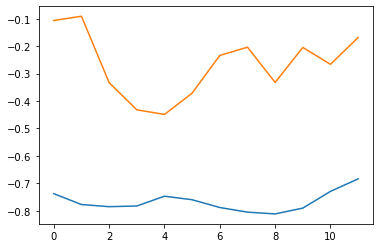

In [248]:
plt.plot(y_test_CNN.sel(var='TLAI', ens='LHC0223'))
plt.plot(mean_cnn[1,:,0])

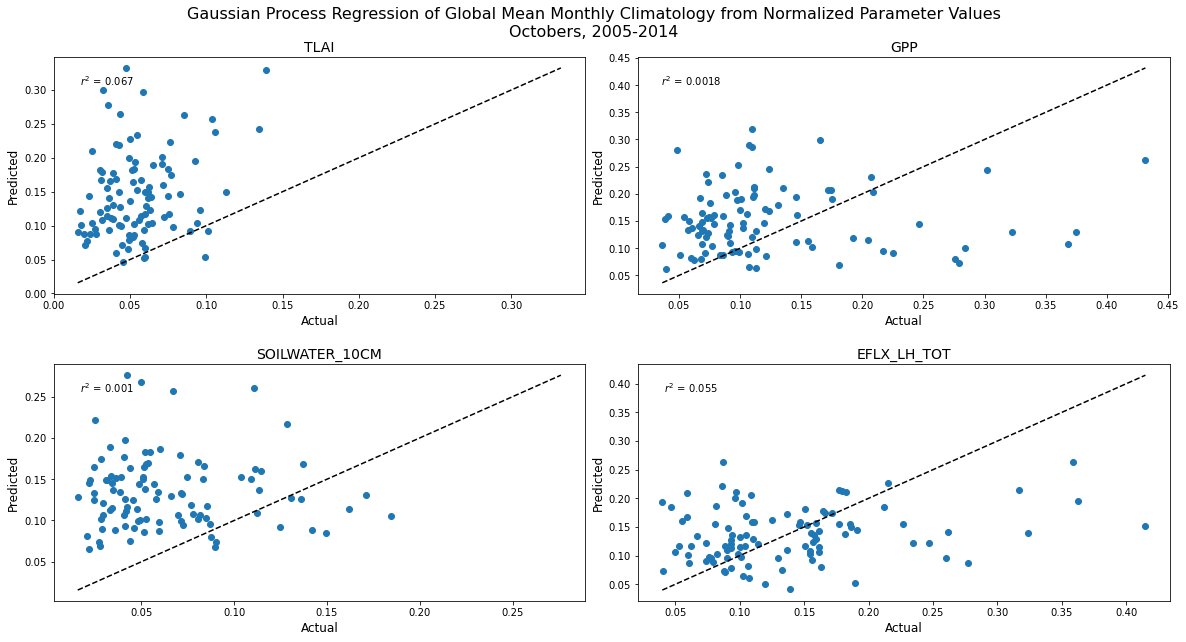

In [245]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

mon=10 # October

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_CNN.sel(var=v).std(dim='month'),mean_cnn[:,:,i].std(axis=1)) # watch the indexing for cnn output
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_CNN.sel(var=v).std(dim='month'),mean_cnn[:,:,i].std(axis=1)]),np.amax([y_test_CNN.sel(var=v).std(dim='month'),mean_cnn[:,:,i].std(axis=1)]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_CNN.sel(var=v).std(dim='month'),mean_cnn[:,:,i].std(axis=1))
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Mean Monthly Climatology from Normalized Parameter Values\nOctobers, 2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);

## Random Forest

### Using ESEm
See: https://esem.readthedocs.io/en/latest/emulation.html#random-forest-emulation \
https://esem.readthedocs.io/en/latest/examples/CRM_Emulation_with_RandomForest.html

In [93]:
from esem import rf_model

In [94]:
xt

<xarray.DataArray (ens: 500, param: 32)>
array([[0.77831114, 0.35802577, 0.25502127, ..., 0.39361723, 0.07896155,
        0.68458797],
       [0.31932864, 0.54880317, 0.63019079, ..., 0.04108439, 0.27561916,
        0.87845469],
       [0.87677181, 0.21079367, 0.6621252 , ..., 0.81974643, 0.84014328,
        0.95191497],
       ...,
       [0.18596905, 0.996422  , 0.42220946, ..., 0.24264258, 0.84227481,
        0.7311443 ],
       [0.26212961, 0.9122803 , 0.5339336 , ..., 0.71595008, 0.35301486,
        0.3580522 ],
       [0.42211367, 0.83921159, 0.14434242, ..., 0.21237027, 0.36344002,
        0.1567103 ]])
Coordinates:
  * param    (param) object 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [95]:
#x_train_RF,x_test_RF,y_train_RF,y_test_RF = train_test_split(xt,yt,test_size=0.2,train_size=0.8) # RF are invariant to rescaling, use raw output
#x_train_RF,x_test_RF,y_train_RF,y_test_RF = train_test_split(xt,y_scale,test_size=0.2,train_size=0.8) # test rescaled output
x_train_RF,x_test_RF,y_train_RF,y_test_RF = train_test_split(xt,y_scale.sel(var='TLAI'),test_size=0.2,train_size=0.8) # TLAI only

In [96]:
model_rf = rf_model(x_train_RF.values, y_train_RF.values)

In [97]:
model_rf.train()

/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/esem/model_adaptor.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(X=training_params, y=training_data, **kwargs)


In [98]:
predictions_RF = model_rf.predict(x_test_RF)

In [99]:
predictions_RF[0].shape

(100,)

In [102]:
y_test_RF.shape

(100,)

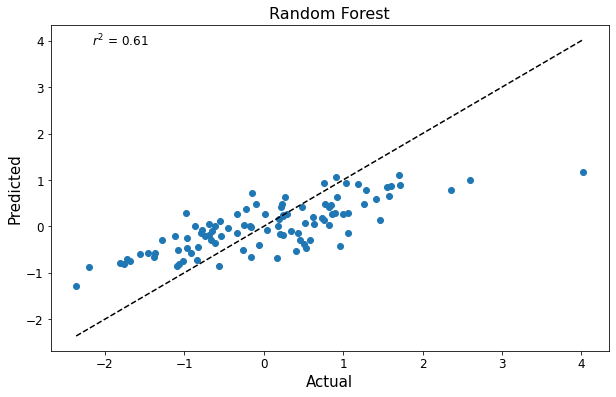

In [106]:
# plot actual vs. predicted - single output
fig = plt.figure(figsize=(10,6))

plt.scatter(y_test_RF,predictions_RF[0])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# bounds for one-to-one line
bounds = (np.amin([y_test_RF,predictions_RF[0]]),np.amax([y_test_RF,predictions_RF[0]]))

# one-to-one line
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

# r^2 calculation and display
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_RF,predictions_RF[0])
pltstr = "$r^2$ = %.2g" % r_value**2
plt.text(-1.8, 4, pltstr, horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.title('Random Forest', fontsize=16)
    
#plt.savefig('../figs/lhc/TLAI_GM_AM_RF_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [107]:
predictions_RF[0].min()

-1.2743591986703375

In [108]:
predictions_RF[0].max()

1.1613504605359077

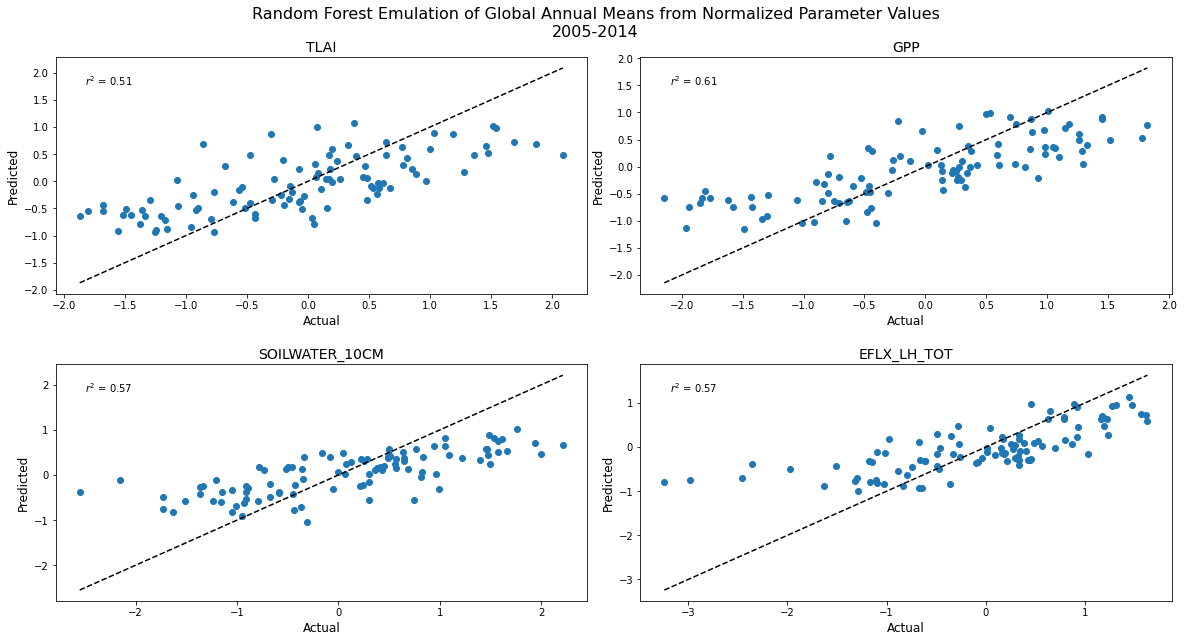

In [297]:
# plot actual vs. predicted - multiple outputs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_RF.sel(var=v),predictions_RF[0][:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)

    # bounds for one-to-one line
    bounds = (np.amin([y_test_RF.sel(var=v),predictions_RF[0][:,i]]),np.amax([y_test_RF.sel(var=v),predictions_RF[0][:,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_RF.sel(var=v),predictions_RF[0][:,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Random Forest Emulation of Global Annual Means from Normalized Parameter Values\n2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_RF_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')